## ANALYSE IF TRAIN AND TEST SETS ARE DIFFERENT AND WHICH SPLIT METHOD IS BETTER

#### 1. read data, filter rare bacteria and split to train and test using two methods:

    a. Last Block - where we take n last timepoints as test set
 
    b. Shuffled - where we take random timepoints from time series as test set 
    
#### 2. calculate Shannon diversity in each timepoint and compare if its distribution in test and train set are different

#### 3. transform data using CLR and calculate Bray Curtis diversity between train set points, between test set points and between train and test points to see differences


In [ ]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


import os
import sys
import warnings

import skbio
from scipy.spatial import distance
from scipy.stats import ks_2samp

In [2]:
warnings.filterwarnings("ignore")

In [3]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project') # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from utils.measures import calculate_spearman, calculate_nrmse, inter_dissimilarity

MODULE_PATH = os.path.abspath('/storage/zkarwowska/clean_code/data_preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit

In [4]:
donor = 'donorA'

### 1. read data

In [5]:
FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/{}_rarefied_interpolated_feces.csv'.format(donor)

df = pd.read_csv(FILE, index_col = [0])
df.shape

(365, 1531)

### 2. FILTER RARE BACTERIA


In [6]:
processing = MicrobiomeDataPreprocessing()
df_filtered = processing.filter_rare_features(df, treshold_perc = .8)
df_filtered.shape

(365, 149)

#### 3. TRANSFORM USING CLR

In [7]:
transformer = CLRTransformer()
df_filtered_clr = transformer.fit_transform(df_filtered)

#### 4. SPLIT TO TRAIN AND TEST

In [8]:
split = MicrobiomeTraintestSplit()

train_last_block, test_last_block = split.last_block_split(df_filtered)
train_shuffled, test_shuffled= split.blocked_split(df_filtered)

#### 5. CALCULATE ALPHA DIVERSITY
##### A. SHANNON

In [9]:
def calculate_shannon(df, data):
    
    SHANNON_IDX = []
    for i in range(len(df.index)):
        x = df.iloc[i].values
        shannon_idx = skbio.diversity.alpha.shannon(x)
        
        SHANNON_IDX.append(shannon_idx)
        
    shannon_df = pd.DataFrame(SHANNON_IDX, columns = ['shannon_idx'])
    shannon_df['timestep'] = df.index
    shannon_df['data'] = data
    
    return shannon_df

In [10]:
shannon_last_block_df = calculate_shannon(train_last_block, 'train').append(calculate_shannon(test_last_block, 'test'))
shannon_shuffled_df = calculate_shannon(train_shuffled, 'train').append(calculate_shannon(test_shuffled, 'test'))

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.boxplot(data = shannon_last_block_df, y = 'shannon_idx', x = 'data', color = 'white', linewidth = .7, width = .7, ax=ax1)
sns.swarmplot(data = shannon_last_block_df, y = 'shannon_idx', x = 'data', s=2, ax=ax1)

sns.boxplot(data = shannon_shuffled_df, y = 'shannon_idx', x = 'data', color = 'white', linewidth = .7, width = .7, ax=ax2)
sns.swarmplot(data = shannon_shuffled_df, y = 'shannon_idx', x = 'data', s=2, ax=ax2)

ax1.title.set_text('Last Block Split')
ax2.title.set_text('Shuffled Split')

train_patch = mpatches.Patch(color='black', label='train')
test_patch = mpatches.Patch(color='orange', label='test')

ax1.legend(handles=[train_patch, test_patch])
ax2.legend(handles=[train_patch, test_patch])

plt.tight_layout()
plt.savefig('TrainTestSplitAnalysis/{}_shannon_boxplot.png'.format(donor))

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.distplot(shannon_last_block_df[shannon_last_block_df['data'] == 'train']['shannon_idx'], hist = False, color = 'black', ax=ax1)
sns.distplot(shannon_last_block_df[shannon_last_block_df['data'] == 'test']['shannon_idx'], hist = False, color = 'orange', ax=ax1)

sns.distplot(shannon_shuffled_df[shannon_shuffled_df['data'] == 'train']['shannon_idx'], hist = False, color = 'black', ax=ax2)
sns.distplot(shannon_shuffled_df[shannon_shuffled_df['data'] == 'test']['shannon_idx'], hist = False, color = 'orange', ax=ax2)

ax1.title.set_text('Last Block Split')
ax2.title.set_text('Shuffled Split')

train_patch = mpatches.Patch(color='black', label='train')
test_patch = mpatches.Patch(color='orange', label='test')

ax1.legend(handles=[train_patch, test_patch])
ax2.legend(handles=[train_patch, test_patch])


plt.tight_layout()
plt.savefig('TrainTestSplitAnalysis/{}_shannon_dist.png'.format(donor))

#### 6. CALCULATE BETA DIVERSITY BETWEEN AND INSIDE TRAIN AND TEST
##### A. BRAY CURTIS


In [ ]:
split = MicrobiomeTraintestSplit()

train_last_block, test_last_block = split.last_block_split(df_filtered_clr)
train_shuffled, test_shuffled= split.blocked_split(df_filtered_clr)

In [11]:
def calculate_bc(df1, df2, data):
    
    var1=[]
    var2=[]
    bc_dist = []
    for i in range(len(df1.index)):
        for j in range(len(df2.index)):
            dist = distance.braycurtis(df1.iloc[i], df2.iloc[j])
            bc_dist.append(dist)
            var1.append(i)
            var2.append(j)
            
    bc_df = pd.DataFrame(list(zip(var1, var2, bc_dist)), columns = ['idx1', 'idx2', 'bc_dist'])
    bc_df['data'] = data
    
    return bc_df

In [12]:
# last block
bc_last_block_train_train = calculate_bc(train_last_block, train_last_block, 'train_train')
bc_last_block_train_test = calculate_bc(train_last_block, test_last_block, 'train_test')
bc_last_block_test_test = calculate_bc(test_last_block, test_last_block, 'test_test')

bc_last_block_df = bc_last_block_train_train.append(bc_last_block_train_test).append(bc_last_block_test_test)
bc_last_block_df['split'] = 'last block'

In [13]:
# shuffled block
bc_shuffled_train_train = calculate_bc(train_shuffled, train_shuffled, 'train_train')
bc_shuffled_train_test = calculate_bc(train_shuffled, test_shuffled, 'train_test')
bc_shuffled_test_test = calculate_bc(test_shuffled, test_shuffled, 'test_test')

bc_shuffled_df = bc_shuffled_train_train.append(bc_shuffled_train_test).append(bc_shuffled_test_test)
bc_shuffled_df['split'] = 'shuffled'

In [14]:
bc_df = bc_last_block_df.append(bc_shuffled_df)

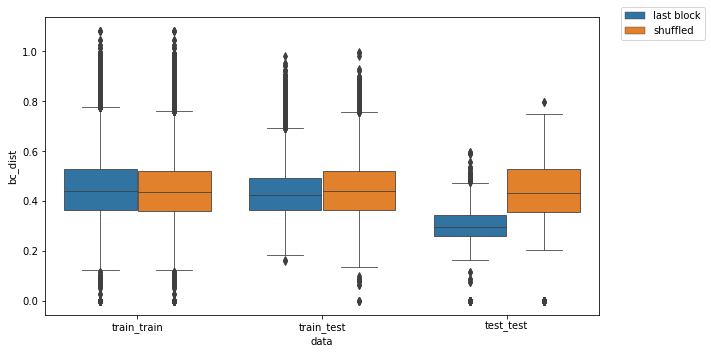

In [15]:
plt.figure(figsize=(10, 5))

ax=sns.boxplot(data=bc_df,
               y = 'bc_dist',
               x = 'data',
               hue = 'split',
              linewidth = .8,
              width = .8)

ax.legend(bbox_to_anchor=(1.2, 1.05))
plt.tight_layout()
plt.savefig('TrainTestSplitAnalysis/{}_bc_boxplot.png'.format(donor))